In [2]:
import pkg_resources
from pkg_resources import DistributionNotFound, VersionConflict
from platform import python_version
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import warnings
warnings.simplefilter("ignore")
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

## Trained on S5926 and predicted S350

In [3]:
df = pd.read_csv('S5296.csv')
print(df.head(5))

  PDB Id Mutated Chain Mutation_PDB    Label UniProt Mutation_UNP  DDGexp  \
0   1A43             A        C218S  forward  P12497        C350S    3.70   
1   1A43             A        C218S  reverse  P12497        S350C   -3.70   
2   1A43             A        E159D  forward  P12497        E291D    4.55   
3   1A43             A        E159D  reverse  P12497        D291E   -4.55   
4   1A43             A        G156A  forward  P12497        G288A    2.40   

  Location    DCS  DOMH  PSSM       P_L  P_RKDE     P_FWY  N_Hydro  N_Charg  \
0      COR -7.158 -0.72    -1  0.069444     0.0  0.069444        4        2   
1      COR  7.156  0.72     8  0.069444     0.0  0.069444        3        2   
2      SUR -2.631 -0.09     2  0.069444     0.0  0.069444        8        9   
3      SUR  2.630  0.09     4  0.069444     0.0  0.069444        8        9   
4      COR -5.275  0.27     0  0.069444     0.0  0.069444        6        8   

   SASA_pro  SASA_sol    PremPS similar proteins  
0        20

In [4]:
descriptive_features = df[['Mutated Chain','Mutation_PDB','Label', "UniProt", "Mutation_UNP",  "DDGexp",  "Location"]]
descriptive_features

,Mutated Chain,Mutation_PDB,Label,UniProt,Mutation_UNP,DDGexp,Location
0,A,C218S,forward,P12497,C350S,3.70,COR
1,A,C218S,reverse,P12497,S350C,-3.70,COR
2,A,E159D,forward,P12497,E291D,4.55,SUR
3,A,E159D,reverse,P12497,D291E,-4.55,SUR
4,A,G156A,forward,P12497,G288A,2.40,COR
...,...,...,...,...,...,...,...
5291,A,Y35F,reverse,P00974,F70Y,-0.60,COR
5292,A,Y35G,forward,P00974,Y70G,5.00,COR
5293,A,Y35G,reverse,P00974,G70Y,-5.00,COR
5294,A,Y35N,forward,P00974,Y70N,3.70,COR


In [5]:
descriptive_features['Mutated Chain'] = pd.factorize(descriptive_features['Mutated Chain'])[0]
descriptive_features['Mutation_PDB'] = pd.factorize(descriptive_features['Mutation_PDB'])[0]
descriptive_features['Label'] = pd.factorize(descriptive_features['Label'])[0]
descriptive_features['UniProt'] = pd.factorize(descriptive_features['UniProt'])[0]
descriptive_features['Mutation_UNP'] = pd.factorize(descriptive_features['Mutation_UNP'])[0]
descriptive_features['Location'] = pd.factorize(descriptive_features['Location'])[0]
descriptive_features.head()

,Mutated Chain,Mutation_PDB,Label,UniProt,Mutation_UNP,DDGexp,Location
0,0,0,0,0,0,3.70,0
1,0,0,1,0,1,-3.70,0
2,0,1,0,0,2,4.55,1
3,0,1,1,0,3,-4.55,1
4,0,2,0,0,4,2.40,0


In [6]:
target_feature = df[['PremPS']]
target_feature

,PremPS
0,1.487019
1,-1.739746
2,0.766227
3,-0.723130
4,1.187639
...,...
5291,-1.909816
5292,3.698962
5293,-3.421731
5294,4.263901


In [7]:
descriptive_features.isnull().sum()

Mutated Chain    0
Mutation_PDB     0
Label            0
UniProt          0
Mutation_UNP     0
DDGexp           0
Location         0
dtype: int64

In [8]:
testing_data = pd.read_excel('350.xlsx')
testing_data

,PDB Id,Mutated Chain,Mutation_PDB,UniProt,Mutation_UNP,Label,DDGexp,Location,PremPS,PremPS_M,PremPS_P
0,9999999999999999920903862628363385082275612169...,A,I7S,P00282,I27S,1,3.44,COR,3.186056,2.769578,2.768110
1,9999999999999999920903862628363385082275612169...,A,I20T,P00282,I40T,1,2.39,COR,2.169456,2.039257,2.430897
2,9999999999999999920903862628363385082275612169...,A,V31T,P00282,V51T,1,1.08,COR,1.360860,1.625162,2.380536
3,9999999999999999920903862628363385082275612169...,A,L50V,P00282,L70V,1,0.36,COR,0.664295,1.037976,1.189084
4,9999999999999999920903862628363385082275612169...,A,V60G,P00282,V80G,1,3.11,COR,2.373845,1.227922,1.428366
...,...,...,...,...,...,...,...,...,...,...,...
345,5DFR,A,G121H,P0ABQ4,G121H,1,0.56,SUR,0.597748,0.863704,1.057653
346,5DFR,A,I155T,P0ABQ4,I155T,1,2.53,COR,1.876904,1.230930,1.052630
347,5PTI,A,A16V,P00974,A51V,1,1.30,SUR,1.361258,1.516875,-0.404462
348,5PTI,A,A16T,P00974,A51T,1,1.70,SUR,1.631536,1.591198,0.299480


In [9]:
testing_descriptive = testing_data[['Mutated Chain','Mutation_PDB','Label', "UniProt", "Mutation_UNP",  "DDGexp",  "Location"]]
testing_descriptive

,Mutated Chain,Mutation_PDB,Label,UniProt,Mutation_UNP,DDGexp,Location
0,A,I7S,1,P00282,I27S,3.44,COR
1,A,I20T,1,P00282,I40T,2.39,COR
2,A,V31T,1,P00282,V51T,1.08,COR
3,A,L50V,1,P00282,L70V,0.36,COR
4,A,V60G,1,P00282,V80G,3.11,COR
...,...,...,...,...,...,...,...
345,A,G121H,1,P0ABQ4,G121H,0.56,SUR
346,A,I155T,1,P0ABQ4,I155T,2.53,COR
347,A,A16V,1,P00974,A51V,1.30,SUR
348,A,A16T,1,P00974,A51T,1.70,SUR


In [10]:
testing_descriptive['Mutated Chain'] = pd.factorize(testing_descriptive['Mutated Chain'])[0]
testing_descriptive['Mutation_PDB'] = pd.factorize(testing_descriptive['Mutation_PDB'])[0]
testing_descriptive['UniProt'] = pd.factorize(testing_descriptive['UniProt'])[0]
testing_descriptive['Mutation_UNP'] = pd.factorize(testing_descriptive['Mutation_UNP'])[0]
testing_descriptive['Location'] = pd.factorize(testing_descriptive['Location'])[0]
testing_descriptive

,Mutated Chain,Mutation_PDB,Label,UniProt,Mutation_UNP,DDGexp,Location
0,0,0,1,0,0,3.44,0
1,0,1,1,0,1,2.39,0
2,0,2,1,0,2,1.08,0
3,0,3,1,0,3,0.36,0
4,0,4,1,0,4,3.11,0
...,...,...,...,...,...,...,...
345,0,342,1,64,344,0.56,1
346,0,343,1,64,345,2.53,0
347,0,344,1,65,346,1.30,1
348,0,345,1,65,347,1.70,1


In [11]:
testing_target = testing_data[['PremPS']]
testing_target

,PremPS
0,3.186056
1,2.169456
2,1.360860
3,0.664295
4,2.373845
...,...
345,0.597748
346,1.876904
347,1.361258
348,1.631536


In [12]:

regressor_RF = RandomForestRegressor(n_estimators=500,criterion='squared_error', 
                                    max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0, max_features=1.0)

regressor_RF.fit(descriptive_features,target_feature) # Training dataset 2*3*4, 24
predicted_values_RF = regressor_RF.predict(testing_descriptive) # 5*6*1 , 48(wrong) 30(actual) 
predicted_values_RF

array([ 1.17580113e+00,  4.91842696e-02, -1.17134914e+00, -2.95654243e-01,
        1.03851350e+00,  1.03851350e+00, -1.62912233e+00, -3.09794820e-01,
       -5.29445899e-01,  1.23851967e+00, -5.49342060e-01, -1.10369116e+00,
       -9.69230951e-01, -5.55909915e-01, -3.29990984e-01, -7.17960727e-01,
       -3.39746206e-01, -4.55536336e-01, -2.16184616e-01, -2.94234867e-01,
       -4.04077243e-01, -3.36162807e-01,  7.61877157e-01, -4.76731699e-01,
       -4.19797558e-01, -3.36162807e-01, -3.31722714e-01,  1.29850789e+00,
       -2.09187296e-01, -8.66633306e-01, -5.94756405e-01, -4.65391845e-01,
       -4.67526085e-01,  2.15965123e-01, -4.69390073e-02, -4.18969889e-01,
       -4.63239800e-01, -3.92729010e-01, -4.93615881e-01, -2.51698751e-01,
        4.62401830e-01, -5.31578384e-01, -6.20990817e-01, -9.41490747e-02,
        2.92075939e-01, -1.66138426e+00, -2.06142203e+00, -2.20850202e+00,
       -5.45025421e-01, -5.94291212e-01, -6.85621226e-01, -2.21110313e-01,
       -6.07191978e-01,  

In [13]:
testing_data['Predicted PremPS'] = predicted_values_RF

In [14]:
testing_data

,PDB Id,Mutated Chain,Mutation_PDB,UniProt,Mutation_UNP,Label,DDGexp,Location,PremPS,PremPS_M,PremPS_P,Predicted PremPS
0,9999999999999999920903862628363385082275612169...,A,I7S,P00282,I27S,1,3.44,COR,3.186056,2.769578,2.768110,1.175801
1,9999999999999999920903862628363385082275612169...,A,I20T,P00282,I40T,1,2.39,COR,2.169456,2.039257,2.430897,0.049184
2,9999999999999999920903862628363385082275612169...,A,V31T,P00282,V51T,1,1.08,COR,1.360860,1.625162,2.380536,-1.171349
3,9999999999999999920903862628363385082275612169...,A,L50V,P00282,L70V,1,0.36,COR,0.664295,1.037976,1.189084,-0.295654
4,9999999999999999920903862628363385082275612169...,A,V60G,P00282,V80G,1,3.11,COR,2.373845,1.227922,1.428366,1.038513
...,...,...,...,...,...,...,...,...,...,...,...,...
345,5DFR,A,G121H,P0ABQ4,G121H,1,0.56,SUR,0.597748,0.863704,1.057653,-0.076103
346,5DFR,A,I155T,P0ABQ4,I155T,1,2.53,COR,1.876904,1.230930,1.052630,0.276143
347,5PTI,A,A16V,P00974,A51V,1,1.30,SUR,1.361258,1.516875,-0.404462,-0.140698
348,5PTI,A,A16T,P00974,A51T,1,1.70,SUR,1.631536,1.591198,0.299480,0.133987


In [15]:
import math
mse = mean_squared_error(testing_target, predicted_values_RF)
rmse = math.sqrt(mse)
rmse

1.3625535366359047

## Retrain on S5926 without Labels and predicted S921

In [16]:
# error will occur if no label exists
descriptive_features_without_label = descriptive_features.drop('Label', axis =1) 


In [17]:
descriptive_features_without_label

,Mutated Chain,Mutation_PDB,UniProt,Mutation_UNP,DDGexp,Location
0,0,0,0,0,3.70,0
1,0,0,0,1,-3.70,0
2,0,1,0,2,4.55,1
3,0,1,0,3,-4.55,1
4,0,2,0,4,2.40,0
...,...,...,...,...,...,...
5291,0,2440,128,4911,-0.60,0
5292,0,2441,128,4912,5.00,0
5293,0,2441,128,4913,-5.00,0
5294,0,2442,128,4914,3.70,0


In [18]:
target_feature_without_label = target_feature # S5296
target_feature_without_label

,PremPS
0,1.487019
1,-1.739746
2,0.766227
3,-0.723130
4,1.187639
...,...
5291,-1.909816
5292,3.698962
5293,-3.421731
5294,4.263901


In [19]:
testing_data_s921 = pd.read_excel('S921.xlsx')
testing_data_s921

,PDB Id,Mutated Chain,Mutation_PDB,UniProt,Mutation_UNP,DDGexp,Location,PremPS,INPS3D,INPS,PoPMuSiC,mCSM,FoldX
0,107L,A,G44S,P00720,G44S,-0.500,SUR,-0.566552,0.182653,-0.280489,0.23,1.144,-0.733663
1,108L,A,I44S,P00720,I44S,0.300,SUR,0.202305,0.835389,1.165360,0.00,0.867,0.252008
2,109L,A,K44S,P00720,K44S,0.200,SUR,-0.145149,0.254589,0.005043,0.60,0.610,0.138615
3,110L,A,L44S,P00720,L44S,0.400,SUR,0.116301,0.824006,0.806203,0.30,0.854,0.365047
4,111L,A,N44S,P00720,N44S,-0.100,SUR,-0.159980,-0.026243,-0.110165,0.06,0.331,-0.164694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,451C,A,Q37R,P00099,Q59R,-0.500,SUR,0.332474,-0.015074,-0.231641,0.29,-0.267,-0.401466
917,451C,A,V13M,P00099,V35M,-0.400,SUR,-0.438337,0.288000,-0.134577,-0.21,0.421,-0.225037
918,451C,A,V78I,P00099,V100I,-1.055,COR,-0.286931,-0.287536,-0.452964,0.19,0.080,-1.001650
919,4LYZ,A,K13D,P00698,K31D,6.700,SUR,0.777545,0.835183,0.699028,1.39,0.256,1.494280


In [20]:
testing_descriptive_s921 = testing_data_s921[['Mutated Chain','Mutation_PDB', "UniProt", "Mutation_UNP",  "DDGexp",  "Location"]]
testing_descriptive_s921

,Mutated Chain,Mutation_PDB,UniProt,Mutation_UNP,DDGexp,Location
0,A,G44S,P00720,G44S,-0.500,SUR
1,A,I44S,P00720,I44S,0.300,SUR
2,A,K44S,P00720,K44S,0.200,SUR
3,A,L44S,P00720,L44S,0.400,SUR
4,A,N44S,P00720,N44S,-0.100,SUR
...,...,...,...,...,...,...
916,A,Q37R,P00099,Q59R,-0.500,SUR
917,A,V13M,P00099,V35M,-0.400,SUR
918,A,V78I,P00099,V100I,-1.055,COR
919,A,K13D,P00698,K31D,6.700,SUR


In [21]:
testing_descriptive_s921['Mutated Chain'] = pd.factorize(testing_descriptive_s921['Mutated Chain'])[0]
testing_descriptive_s921['Mutation_PDB'] = pd.factorize(testing_descriptive_s921['Mutation_PDB'])[0]
testing_descriptive_s921['UniProt'] = pd.factorize(testing_descriptive_s921['UniProt'])[0]
testing_descriptive_s921['Mutation_UNP'] = pd.factorize(testing_descriptive_s921['Mutation_UNP'])[0]
testing_descriptive_s921['Location'] = pd.factorize(testing_descriptive_s921['Location'])[0]
testing_descriptive_s921

,Mutated Chain,Mutation_PDB,UniProt,Mutation_UNP,DDGexp,Location
0,0,0,0,0,-0.500,0
1,0,1,0,1,0.300,0
2,0,2,0,2,0.200,0
3,0,3,0,3,0.400,0
4,0,4,0,4,-0.100,0
...,...,...,...,...,...,...
916,0,894,52,901,-0.500,0
917,0,895,52,902,-0.400,0
918,0,367,52,372,-1.055,1
919,0,896,53,903,6.700,0


In [22]:
testing_target_s921 = testing_data_s921[['PremPS']]
testing_target_s921

,PremPS
0,-0.566552
1,0.202305
2,-0.145149
3,0.116301
4,-0.159980
...,...
916,0.332474
917,-0.438337
918,-0.286931
919,0.777545


In [23]:

regressor_RF_without_label = RandomForestRegressor(n_estimators=500,criterion='squared_error', 
                                    max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0, max_features=1.0)
regressor_RF_without_label.fit(descriptive_features_without_label,target_feature_without_label) # Training dataset 2*3*4, 24
predicted_values_RF_without_label = regressor_RF_without_label.predict(testing_descriptive_s921) # 5*6*1 , 48(wrong) 30(actual) 
predicted_values_RF_without_label

array([ 0.22096911,  0.63557052,  0.36470832,  0.32817015, -0.31550465,
       -1.99589922,  0.36066584,  0.33714071,  0.67180617,  0.56582253,
       -0.31135258, -0.94781028,  0.21068481, -0.03908135, -1.80634957,
       -1.73144745, -0.99355573, -0.57169087,  0.51263985,  0.41044093,
       -1.19875815, -0.07320399,  0.9254086 ,  0.82441018,  0.69536335,
        0.23990388,  0.01417815, -1.36952203,  0.60276322,  0.3036679 ,
        0.47124111,  1.13679419,  0.38279373,  2.24902491,  1.25278548,
        1.32573258,  1.41600597, -0.14654428,  1.09240642, -0.91932109,
        0.12892634,  0.69604254,  0.43900294,  0.23033991,  0.69016554,
       -0.27692579,  0.80225525,  0.55176041,  0.53802721,  0.35068967,
        0.09295014,  1.35831802,  1.88477146,  1.21976576,  1.33936656,
        1.33936656,  1.36512958,  1.36512958,  2.49493105,  1.36359978,
        1.33827908,  1.36359978,  1.96687401,  0.10618942,  1.02777436,
        1.48852764,  2.75946278,  2.49167068,  1.37190951,  1.37

In [24]:
testing_data_s921['Predicted PremPS'] = predicted_values_RF_without_label

In [25]:
testing_data_s921

,PDB Id,Mutated Chain,Mutation_PDB,UniProt,Mutation_UNP,DDGexp,Location,PremPS,INPS3D,INPS,PoPMuSiC,mCSM,FoldX,Predicted PremPS
0,107L,A,G44S,P00720,G44S,-0.500,SUR,-0.566552,0.182653,-0.280489,0.23,1.144,-0.733663,0.220969
1,108L,A,I44S,P00720,I44S,0.300,SUR,0.202305,0.835389,1.165360,0.00,0.867,0.252008,0.635571
2,109L,A,K44S,P00720,K44S,0.200,SUR,-0.145149,0.254589,0.005043,0.60,0.610,0.138615,0.364708
3,110L,A,L44S,P00720,L44S,0.400,SUR,0.116301,0.824006,0.806203,0.30,0.854,0.365047,0.328170
4,111L,A,N44S,P00720,N44S,-0.100,SUR,-0.159980,-0.026243,-0.110165,0.06,0.331,-0.164694,-0.315505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,451C,A,Q37R,P00099,Q59R,-0.500,SUR,0.332474,-0.015074,-0.231641,0.29,-0.267,-0.401466,-0.471438
917,451C,A,V13M,P00099,V35M,-0.400,SUR,-0.438337,0.288000,-0.134577,-0.21,0.421,-0.225037,-0.476051
918,451C,A,V78I,P00099,V100I,-1.055,COR,-0.286931,-0.287536,-0.452964,0.19,0.080,-1.001650,-0.460906
919,4LYZ,A,K13D,P00698,K31D,6.700,SUR,0.777545,0.835183,0.699028,1.39,0.256,1.494280,2.405866


In [26]:
import math
mse_s921 = mean_squared_error(testing_target_s921, predicted_values_RF_without_label)
rmse_s921 = math.sqrt(mse)
rmse_s921

1.3625535366359047

## Cross validation within S5296

In [27]:
df_cv = pd.read_csv('S5296.csv')
print(df_cv.head(5))

  PDB Id Mutated Chain Mutation_PDB    Label UniProt Mutation_UNP  DDGexp  \
0   1A43             A        C218S  forward  P12497        C350S    3.70   
1   1A43             A        C218S  reverse  P12497        S350C   -3.70   
2   1A43             A        E159D  forward  P12497        E291D    4.55   
3   1A43             A        E159D  reverse  P12497        D291E   -4.55   
4   1A43             A        G156A  forward  P12497        G288A    2.40   

  Location    DCS  DOMH  PSSM       P_L  P_RKDE     P_FWY  N_Hydro  N_Charg  \
0      COR -7.158 -0.72    -1  0.069444     0.0  0.069444        4        2   
1      COR  7.156  0.72     8  0.069444     0.0  0.069444        3        2   
2      SUR -2.631 -0.09     2  0.069444     0.0  0.069444        8        9   
3      SUR  2.630  0.09     4  0.069444     0.0  0.069444        8        9   
4      COR -5.275  0.27     0  0.069444     0.0  0.069444        6        8   

   SASA_pro  SASA_sol    PremPS similar proteins  
0        20

In [28]:
descriptive_features_cv = df_cv.iloc[:,1:-2]
descriptive_features_cv

,Mutated Chain,Mutation_PDB,Label,UniProt,Mutation_UNP,DDGexp,Location,DCS,DOMH,PSSM,P_L,P_RKDE,P_FWY,N_Hydro,N_Charg,SASA_pro,SASA_sol
0,A,C218S,forward,P12497,C350S,3.70,COR,-7.158,-0.72,-1,0.069444,0.000000,0.069444,4,2,20,146.1
1,A,C218S,reverse,P12497,S350C,-3.70,COR,7.156,0.72,8,0.069444,0.000000,0.069444,3,2,12,129.8
2,A,E159D,forward,P12497,E291D,4.55,SUR,-2.631,-0.09,2,0.069444,0.000000,0.069444,8,9,43,186.2
3,A,E159D,reverse,P12497,D291E,-4.55,SUR,2.630,0.09,4,0.069444,0.000000,0.069444,8,9,74,158.7
4,A,G156A,forward,P12497,G288A,2.40,COR,-5.275,0.27,0,0.069444,0.000000,0.069444,6,8,17,88.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5291,A,Y35F,reverse,P00974,F70Y,-0.60,COR,3.864,-0.25,10,0.000000,0.017241,0.103448,7,5,10,222.8
5292,A,Y35G,forward,P00974,Y70G,5.00,COR,-9.586,-2.34,-9,0.000000,0.034483,0.103448,7,5,13,236.8
5293,A,Y35G,reverse,P00974,G70Y,-5.00,COR,9.586,2.34,10,0.000000,0.000000,0.086207,6,5,5,88.1
5294,A,Y35N,forward,P00974,Y70N,3.70,COR,-8.558,-2.59,-8,0.000000,0.034483,0.103448,7,5,13,236.8


In [29]:
descriptive_features_cv['Mutated Chain'] = pd.factorize(descriptive_features_cv['Mutated Chain'])[0]
descriptive_features_cv['Mutation_PDB'] = pd.factorize(descriptive_features_cv['Mutation_PDB'])[0]
descriptive_features_cv['Label'] = pd.factorize(descriptive_features_cv['Label'])[0]
descriptive_features_cv['UniProt'] = pd.factorize(descriptive_features_cv['UniProt'])[0]
descriptive_features_cv['Mutation_UNP'] = pd.factorize(descriptive_features_cv['Mutation_UNP'])[0]
descriptive_features_cv['Location'] = pd.factorize(descriptive_features_cv['Location'])[0]
descriptive_features_cv

,Mutated Chain,Mutation_PDB,Label,UniProt,Mutation_UNP,DDGexp,Location,DCS,DOMH,PSSM,P_L,P_RKDE,P_FWY,N_Hydro,N_Charg,SASA_pro,SASA_sol
0,0,0,0,0,0,3.70,0,-7.158,-0.72,-1,0.069444,0.000000,0.069444,4,2,20,146.1
1,0,0,1,0,1,-3.70,0,7.156,0.72,8,0.069444,0.000000,0.069444,3,2,12,129.8
2,0,1,0,0,2,4.55,1,-2.631,-0.09,2,0.069444,0.000000,0.069444,8,9,43,186.2
3,0,1,1,0,3,-4.55,1,2.630,0.09,4,0.069444,0.000000,0.069444,8,9,74,158.7
4,0,2,0,0,4,2.40,0,-5.275,0.27,0,0.069444,0.000000,0.069444,6,8,17,88.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5291,0,2440,1,128,4911,-0.60,0,3.864,-0.25,10,0.000000,0.017241,0.103448,7,5,10,222.8
5292,0,2441,0,128,4912,5.00,0,-9.586,-2.34,-9,0.000000,0.034483,0.103448,7,5,13,236.8
5293,0,2441,1,128,4913,-5.00,0,9.586,2.34,10,0.000000,0.000000,0.086207,6,5,5,88.1
5294,0,2442,0,128,4914,3.70,0,-8.558,-2.59,-8,0.000000,0.034483,0.103448,7,5,13,236.8


In [30]:
target_feature_cv = df_cv[['PremPS']]
target_feature_cv

,PremPS
0,1.487019
1,-1.739746
2,0.766227
3,-0.723130
4,1.187639
...,...
5291,-1.909816
5292,3.698962
5293,-3.421731
5294,4.263901


In [31]:
descriptive_features_cv.isnull().sum()

Mutated Chain    0
Mutation_PDB     0
Label            0
UniProt          0
Mutation_UNP     0
DDGexp           0
Location         0
DCS              0
DOMH             0
PSSM             0
P_L              0
P_RKDE           0
P_FWY            0
N_Hydro          0
N_Charg          0
SASA_pro         0
SASA_sol         0
dtype: int64

In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(descriptive_features_cv, target_feature_cv, test_size = 0.2,random_state = 42)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((4236, 17), (4236, 1), (1060, 17), (1060, 1))

### Random Forest

In [33]:

regressor_RF_cv = RandomForestRegressor(n_estimators=500,criterion='squared_error', 
                                    max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0, max_features=1.0)

regressor_RF_cv.fit(X_train,y_train) # Training dataset 2*3*4, 24
predicted_values_RF_cv = regressor_RF_cv.predict(X_test) # 5*6*1 , 48(wrong) 30(actual) 
predicted_values_RF_cv

array([ 0.5988079 , -1.30825504, -1.12674451, ...,  3.50506463,
        1.03479038, -0.93086139])

### SVM

In [34]:
svc_cv = SVR(kernel="rbf", C=100)
svc_cv.fit(X_train,y_train) # Training dataset 2*3*4, 24
predicted_values_svr_cv = svc_cv.predict(X_test) # 5*6*1 , 48(wrong) 30(actual) 
predicted_values_svr_cv

array([ 0.39102055, -0.73703156,  1.05905019, ...,  1.31997598,
        1.22653524, -1.09143537])

### XG Boost GradientBoostingClassifier

In [35]:
xgb_cv = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
xgb_cv.fit(X_train,y_train) # Training dataset 2*3*4, 24
predicted_values_xgb_cv = xgb_cv.predict(X_test) # 5*6*1 , 48(wrong) 30(actual) 
predicted_values_xgb_cv


array([ 0.5606251 , -1.15019501, -0.11202182, ...,  3.01930557,
        1.4051268 , -1.15942476])

In [36]:
predicted_values_RF_cv.shape,predicted_values_svr_cv.shape,predicted_values_xgb_cv.shape

((1060,), (1060,), (1060,))

In [37]:
y_test_evaluate = y_test

In [38]:
y_test_evaluate['Predicted PremPS Random Forest'] = predicted_values_RF_cv
y_test_evaluate['Predicted PremPS SVM'] = predicted_values_svr_cv
y_test_evaluate['Predicted PremPS XG Boost']=predicted_values_xgb_cv

In [39]:
y_test_evaluate

,PremPS,Predicted PremPS Random Forest,Predicted PremPS SVM,Predicted PremPS XG Boost
422,1.213587,0.598808,0.391021,0.560625
1101,-1.277986,-1.308255,-0.737032,-1.150195
810,-1.245039,-1.126745,1.059050,-0.112022
4262,3.028420,2.461105,1.114343,2.080819
5183,-0.551465,-0.628878,-0.174793,-0.982019
...,...,...,...,...
4573,-0.297443,-0.657158,-0.213209,-0.961628
2277,-1.199636,-1.092124,-1.097741,-1.278946
3226,3.446787,3.505065,1.319976,3.019306
602,1.304361,1.034790,1.226535,1.405127


In [40]:
y_test_evaluate.shape

(1060, 4)

### Random Forrest Regressor

In [41]:
import math
mse_cv_rf = mean_squared_error(y_test.PremPS, predicted_values_RF_cv)
rmse_cv_rf = math.sqrt(mse_cv_rf)
rmse_cv_rf

0.35437538657275813

### Support vector machine

In [42]:
mse_cv_svr = mean_squared_error(y_test.PremPS, predicted_values_svr_cv)
rmse_cv_svr = math.sqrt(mse_cv_svr)
rmse_cv_svr

0.8763273827093183

### XG Boost

In [43]:
mse_cv_xgb = mean_squared_error(y_test.PremPS, predicted_values_xgb_cv)
rmse_cv_xgb = math.sqrt(mse_cv_xgb)
rmse_cv_xgb

0.5146315951238956

In [44]:
corr = y_test.corr(method='pearson', min_periods=1)
R_value_RF=corr.values[0][1]
R_value_svr = corr.values[0][2]
R_value_xgb = corr.values[0][3]


In [45]:
R_value_RF,R_value_svr,R_value_xgb

(0.9655696757735357, 0.806840641529329, 0.9252454999225845)

In [46]:
print(corr)

                                  PremPS  Predicted PremPS Random Forest  \
PremPS                          1.000000                        0.965570   
Predicted PremPS Random Forest  0.965570                        1.000000   
Predicted PremPS SVM            0.806841                        0.824409   
Predicted PremPS XG Boost       0.925245                        0.961114   

                                Predicted PremPS SVM  \
PremPS                                      0.806841   
Predicted PremPS Random Forest              0.824409   
Predicted PremPS SVM                        1.000000   
Predicted PremPS XG Boost                   0.860124   

                                Predicted PremPS XG Boost  
PremPS                                           0.925245  
Predicted PremPS Random Forest                   0.961114  
Predicted PremPS SVM                             0.860124  
Predicted PremPS XG Boost                        1.000000  


<AxesSubplot:>

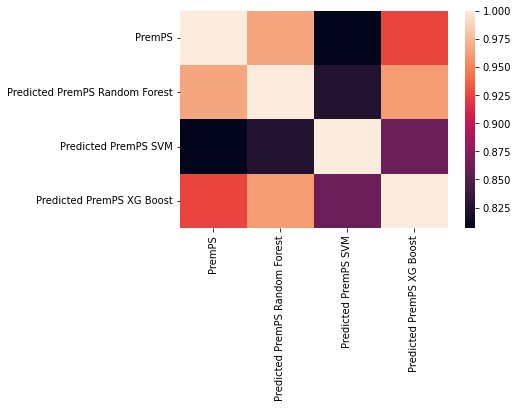

In [47]:
import seaborn as sns
sns.heatmap(corr)